In [6]:
# %% Imports
import os, pickle, json, math, warnings, datetime as dt
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error,
    mean_absolute_percentage_error
)

# Optional – SHAP is heavy; skip if not installed
try:
    import shap
    shap.initjs()
except ImportError:
    shap = None
    warnings.warn("SHAP not installed – skipping explainability step.")

# %% Paths
BASE      = Path(".")            # repo root
FT_DIR    = BASE / "data" / "features"
MODEL_DIR = BASE / "models"
REP_DIR   = BASE / "reports"

TRAIN_FE  = FT_DIR / "train_fe.parquet"
TEST_FE   = FT_DIR / "test_fe.parquet"
MODEL_PKL = max(MODEL_DIR.glob("xgb_rossmann_*.pkl"), key=os.path.getmtime)

pd.options.display.float_format = "{:,.2f}".format
print(f"Using model: {MODEL_PKL.name}")


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using model: xgb_rossmann_20250623-183126.pkl


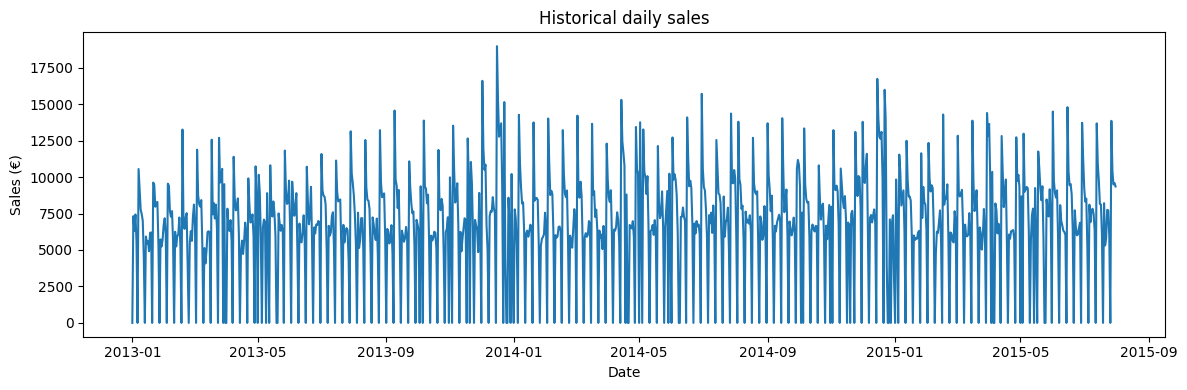

In [9]:
# %% Weekly sales profile for a random store
store_id = np.random.choice(train["Store"].unique())
sample   = train[train["Store"] == store_id].sort_values("Date")

plt.figure(figsize=(12,4))
plt.plot(sample["Date"], sample["Sales"], label=f"Store {store_id}")
plt.title("Historical daily sales")
plt.ylabel("Sales (€)")
plt.xlabel("Date")
plt.tight_layout()
plt.show()


In [15]:

# %% Load fitted XGBRegressor
with open(MODEL_PKL, "rb") as f:
    model: xgb.XGBRegressor = pickle.load(f)

print(model)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=600,
             n_jobs=4, num_parallel_tree=None, ...)


RMSE  450.21
MAE   317.24
MAPE  5.81%
RMSPE 7.87%


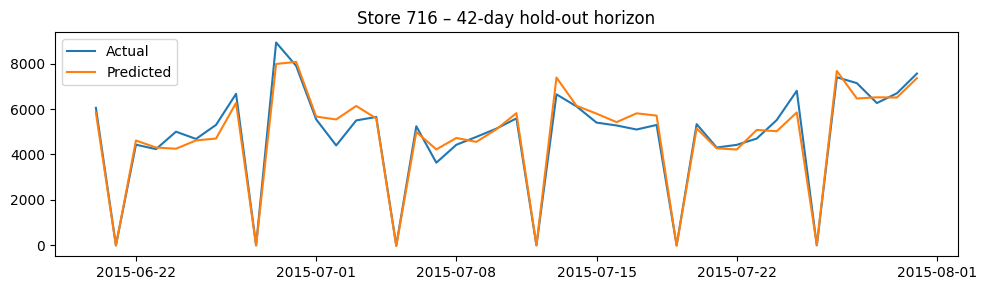

In [20]:
# ──────────────────────────────────────────────────────────────────────────────
# Hold-out evaluation for Rossmann XGBoost model (42-day horizon)
# Handles:
#   • dtype encoding
#   • divide-by-zero-safe MAPE/RMSPE
#   • strict column alignment (adds missing, drops extras, keeps order)
# ──────────────────────────────────────────────────────────────────────────────
import math
from pathlib import Path
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 📌 paths
FEATURE_DIR = Path("data/features")
MODEL_PATH  = Path("models/xgb_rossmann_20250623-183126.pkl")   # adjust

train = pd.read_parquet(FEATURE_DIR / "train_fe.parquet")

with open(MODEL_PATH, "rb") as f:
    model = pickle.load(f)        # wrapper or raw XGBRegressor

# ───────────────────────── helpers ────────────────────────────
def _encode_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    for c in df.columns:
        if pd.api.types.is_datetime64_any_dtype(df[c]):
            df[c] = (df[c] - pd.Timestamp("1970-01-01")).dt.days.astype("int32")
        elif df[c].dtype == "object":
            df[c] = df[c].astype("category")
    return df

def safe_mape(y, ŷ):
    m = y != 0
    return np.mean(np.abs((y[m] - ŷ[m]) / y[m]))

def safe_rmspe(y, ŷ):
    m = y != 0
    return np.sqrt(np.mean(np.square((y[m] - ŷ[m]) / y[m])))

def align_features(df: pd.DataFrame, feat_list: list[str]) -> pd.DataFrame:
    """Add any missing cols (filled with 0) and drop / reorder to feat_list."""
    missing = [c for c in feat_list if c not in df.columns]
    for col in missing:
        # choose a neutral dtype:  int32 zeros for numerics, category 'NA' for cats
        df[col] = 0
    extra = [c for c in df.columns if c not in feat_list]
    df = df.drop(columns=extra)
    return df[feat_list]   # correct order
# ───────────────────────── hold-out set ───────────────────────
HORIZON_DAYS = 42
cutoff = train["Date"].max() - pd.Timedelta(days=HORIZON_DAYS - 1)
holdout = train[train["Date"] >= cutoff].copy()

X_hold = holdout.drop(columns=["Sales", "Id"], errors="ignore")
X_hold = _encode_dataframe(X_hold)

feat_list = model.get_booster().feature_names
X_hold    = align_features(X_hold, feat_list)

y_true = holdout["Sales"].values
y_pred = model.predict(X_hold)

rmse  = math.sqrt(mean_squared_error(y_true, y_pred))
mae   = mean_absolute_error(y_true, y_pred)
mape  = safe_mape(y_true, y_pred)
rmspe = safe_rmspe(y_true, y_pred)

print(f"RMSE  {rmse:,.2f}")
print(f"MAE   {mae:,.2f}")
print(f"MAPE  {mape:,.2%}")
print(f"RMSPE {rmspe:,.2%}")

# ───────────────────── plot one store ─────────────────────────
sid = np.random.choice(holdout["Store"].unique())
tmp = holdout[holdout["Store"] == sid].copy()

X_tmp = _encode_dataframe(tmp.drop(columns=["Sales", "Id"], errors="ignore"))
X_tmp = align_features(X_tmp, feat_list)

tmp["Pred"] = model.predict(X_tmp)

plt.figure(figsize=(10, 3))
plt.plot(tmp["Date"], tmp["Sales"], label="Actual")
plt.plot(tmp["Date"], tmp["Pred"], label="Predicted")
plt.title(f"Store {sid} – 42-day hold-out horizon")
plt.legend(); plt.tight_layout(); plt.show()


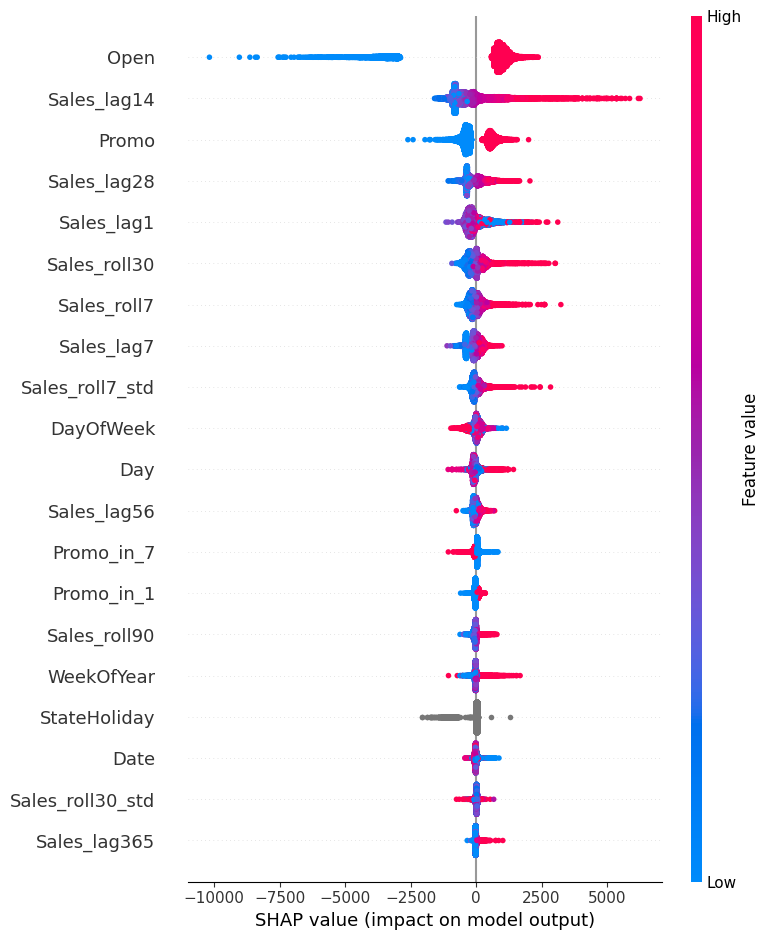

In [21]:
# ───────────────────────────── SHAP GLOBAL SUMMARY ───────────────────────────
import shap
import numpy as np
import matplotlib.pyplot as plt

# -------- helpers (already defined earlier, repeated for clarity) -------------
def _encode_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    for c in df.columns:
        if pd.api.types.is_datetime64_any_dtype(df[c]):
            df[c] = (df[c] - pd.Timestamp("1970-01-01")).dt.days.astype("int32")
        elif df[c].dtype == "object":
            df[c] = df[c].astype("category")
    return df

def align_features(df: pd.DataFrame, feat_list: list[str]) -> pd.DataFrame:
    missing = [c for c in feat_list if c not in df.columns]
    for col in missing:
        df[col] = 0                         # neutral filler
    df = df.drop(columns=[c for c in df.columns if c not in feat_list])
    return df[feat_list]

# -------- prepare a 10 000-row sample in the right schema ---------------------
sample_X = (
    train
    .sample(10_000, random_state=42)
    .drop(columns=["Sales", "Id"], errors="ignore")
    .pipe(_encode_dataframe)
    .pipe(align_features, feat_list)        # feat_list came from model.get_booster()
)

# -------- build explainer & plot summary -------------------------------------
explainer = shap.TreeExplainer(model)       # works for XGBRegressor or wrapper
shap_values = explainer(sample_X)

shap.summary_plot(shap_values, sample_X, show=False)
plt.tight_layout(); plt.show()


Saved: reports\forecast_20250624-012741.csv


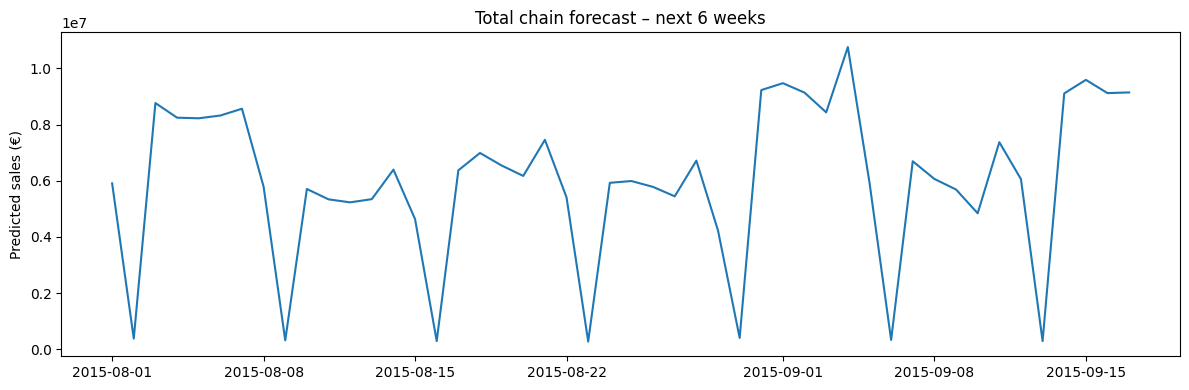

In [25]:
# ───────────────────────── 6-week Kaggle forecast (memory-safe) ───────────────
import datetime as dt
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

REP_DIR = Path("reports"); REP_DIR.mkdir(exist_ok=True)

# 1) engineered features: rows are uniquely (Store, Date)
test_fe = pd.read_parquet("data/features/test_fe.parquet")

# 2) raw Kaggle test (Id, Store, Date) with proper datetime dtype
raw_test = pd.read_csv(
    "data/raw/test.csv",
    usecols=["Id", "Store", "Date"],
    parse_dates=["Date"]
)

# 3) one-to-one merge on Store **and** Date  → 41 088 rows, no explosion
test = test_fe.merge(raw_test, on=["Store", "Date"], how="left", validate="one_to_one")

# 4) encode & align
X_test = (
    test.drop(columns=["Id", "Date"], errors="ignore")
        .pipe(_encode_dataframe)
        .pipe(align_features, feat_list)     # feat_list from booster
)

# 5) predict
forecast_vals = model.predict(X_test).clip(min=0)

forecast = (
    pd.DataFrame({"Id": test["Id"].astype(int), "Sales": forecast_vals})
      .sort_values("Id")
)

stamp = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
fc_csv = REP_DIR / f"forecast_{stamp}.csv"
forecast.to_csv(fc_csv, index=False)
print(f"Saved: {fc_csv}")

# 6) quick sanity-check plot
agg = forecast.join(test[["Date"]])
plt.figure(figsize=(12,4))
plt.plot(agg.groupby("Date")["Sales"].sum())
plt.title("Total chain forecast – next 6 weeks")
plt.ylabel("Predicted sales (€)")
plt.tight_layout(); plt.show()
